In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense

# Load data
df = pd.read_csv("../data/processed/sample_power_data.csv", parse_dates=["datetime"], index_col="datetime")
df = df.sort_index()

# Focus on just one feature for now
data = df[["Global_active_power"]].copy()

# Normalize
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Create sequences
SEQ_LEN = 60  # e.g. 60 timesteps (~10 hours)

def create_sequences(data, seq_len):
    xs, ys = [], []
    for i in range(len(data) - seq_len):
        x = data[i:(i + seq_len)]
        y = data[i + seq_len]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

X, y = create_sequences(data_scaled, SEQ_LEN)
print(f"X shape: {X.shape}")

# Split into train/test
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]


X shape: (14340, 60, 1)


In [2]:
# Define model
input_dim = X_train.shape[2]
timesteps = X_train.shape[1]

inputs = Input(shape=(timesteps, input_dim))
encoded = LSTM(64, activation="relu", return_sequences=False)(inputs)
decoded = RepeatVector(timesteps)(encoded)
decoded = LSTM(64, activation="relu", return_sequences=True)(decoded)
decoded = TimeDistributed(Dense(input_dim))(decoded)

autoencoder = Model(inputs, decoded)
autoencoder.compile(optimizer="adam", loss="mse")
autoencoder.summary()

# Train
history = autoencoder.fit(X_train, X_train, epochs=20, batch_size=32,
                          validation_split=0.1, shuffle=False)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 60, 1)          │            65 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,985 (195.25 KB)

 Trainable params: 49,985 (195.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
323/323 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 0.0177 - val_loss: 0.0130
Epoch 2/20
323/323 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0150 - val_loss: 0.0109
Epoch 3/20
323/323 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0113 - val_loss: 0.0080
Epoch 4/20
323/323 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0097 - val_loss: 0.0081
Epoch 5/20
323/323 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0086 - val_loss: 0.0076
Epoch 6/20
323/323 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0095 - val_loss: 0.0071
Epoch 7/20
323/323 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0077 - val_loss: 0.0105
Epoch 8/20
323/323 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 0.0086 - val_loss: 0.0094
Epoch 9/20
323/323 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0080 - val_loss: 0.0093
Epoch 10/20
323/323 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0090 - val_loss: 0.0068
Epoch 11/20
323/323 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0074 - val_loss: 0.0074
Epoch 12/20
323/323 ━━━━━━━━━━━━━━━━━━━━ 

In [5]:
# Predict reconstruction on test
X_pred = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - X_pred, 2), axis=(1,2))

# Threshold based on training data (or fixed quantile)
threshold = np.percentile(mse, 95)
print(f"Anomaly threshold: {threshold:.6f}")

# Flag anomalies
anomaly_flags = mse > threshold

# Create aligned result with full datetime index
full_df = df.copy()
full_df["anomaly_lstm"] = 0  # default to 0

# Compute where LSTM anomalies start (we lose SEQ_LEN rows during sequence prep)
start_idx = len(full_df) - len(anomaly_flags)

# Fill in predictions from that index onward
full_df.iloc[start_idx:, full_df.columns.get_loc("anomaly_lstm")] = anomaly_flags.astype(int)

# Save aligned result
full_df.to_csv("../data/processed/lstm_anomaly_output.csv")
print("✅ LSTM anomalies aligned and saved.")



90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Anomaly threshold: 0.025760
✅ LSTM anomalies aligned and saved.


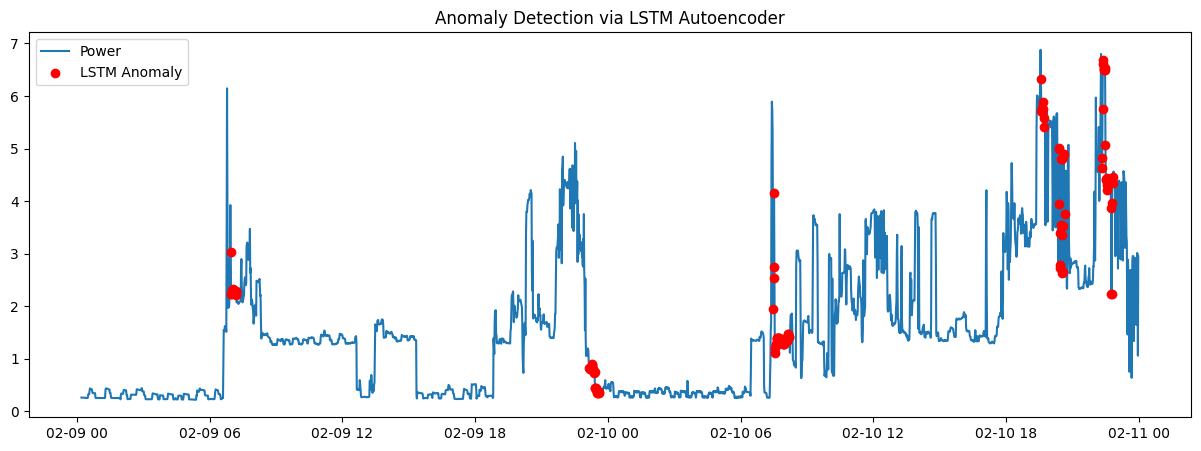

In [6]:
plt.figure(figsize=(15, 5))
plt.plot(anomaly_df.index, anomaly_df["Global_active_power"], label="Power")
plt.scatter(anomaly_df[anomaly_df["anomaly_lstm"] == 1].index,
            anomaly_df[anomaly_df["anomaly_lstm"] == 1]["Global_active_power"],
            color="red", label="LSTM Anomaly", zorder=3)
plt.legend()
plt.title("Anomaly Detection via LSTM Autoencoder")
plt.show()
